# **Geography Analysis**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (5,3)
import tqdm
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import pylab as pl
from matplotlib import collections  as mc
from sklearn.preprocessing import StandardScaler

## Data Preparation

In [2]:
path_folder = os.getcwd()

file_name_oa_offers = "offer_acceptance_offers.csv"
path_file_oa_offers = os.path.join(path_folder, file_name_oa_offers)
oa_offers = pd.read_csv(path_file_oa_offers)
print("Loaded offers df")
print(oa_offers.shape)

file_name_oa_orders = "offer_acceptance_orders.csv"
path_file_oa_orders = os.path.join(path_folder, file_name_oa_orders)
oa_orders = pd.read_csv(path_file_oa_orders)
print("Loaded orders df")
print(oa_orders.shape)

Loaded offers df
(707418, 14)
Loaded orders df
(280906, 17)


c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (9,10,11,12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
file_name_zipcode_coordinates = "zipcode_coordinates.csv"
path_file_zipcode_coordinates = os.path.join(path_folder, file_name_zipcode_coordinates)
zipcode_coordinates = pd.read_csv(path_file_zipcode_coordinates)
zipcode_coordinates["X_COORD"] /= 1.0e6
zipcode_coordinates["Y_COORD"] /= 1.0e6
print("Loaded zipcodes df")

Loaded zipcodes df


In [4]:
zipcode_coordinates["3DIGIT_ZIP"] = zipcode_coordinates["3DIGIT_ZIP"].astype(int).astype(str).str.zfill(3)

oa_orders = (
    oa_orders
    .merge(zipcode_coordinates, left_on=["DESTINATION_3DIGIT_ZIP"], right_on=["3DIGIT_ZIP"])
    .rename(columns={"X_COORD":"X_COORD_DEST","Y_COORD":"Y_COORD_DEST"})
    .drop(columns=["3DIGIT_ZIP"])
)

oa_orders = (
    oa_orders
    .merge(zipcode_coordinates, left_on=["ORIGIN_3DIGIT_ZIP"], right_on=["3DIGIT_ZIP"])
    .drop(columns=["3DIGIT_ZIP"])
)

In [5]:
def dataclean_ftl_duplicate_references(oa_orders):
    '''
    Part of a greater data cleaning on removing incorrect FTL labels,
    Removes FTL rows that have reference numbers that show up more than once, as those rows are incorrectly labeled FTL
    '''
    assert "TRANSPORT_MODE" in oa_orders.columns
    assert "REFERENCE_NUMBER" in oa_orders.columns
    oa_orders_ftl = oa_orders[oa_orders["TRANSPORT_MODE"]=="FTL"]
    oa_orders_ftl_unique = oa_orders_ftl.drop_duplicates(subset=["REFERENCE_NUMBER"],keep=False)
    oa_orders = pd.concat([oa_orders[oa_orders["TRANSPORT_MODE"]!="FTL"], oa_orders_ftl_unique],axis=0)
    oa_orders = oa_orders.reset_index(drop=True)
    assert (oa_orders[oa_orders["TRANSPORT_MODE"]=="FTL"]["REFERENCE_NUMBER"].value_counts()==1).all()
    return oa_orders
def dataclean_ftl_nonquote(oa):
    '''
    Part of a greater data cleaning on removing incorrect FTL labels,
    Removes FTL rows that don't have quote as the transport mode
    '''
    assert "OFFER_TYPE" in oa.columns
    assert "TRANSPORT_MODE" in oa.columns    
    oa = oa[~((oa["TRANSPORT_MODE"]=="FTL") & (oa["OFFER_TYPE"]!="quote"))]
    return oa



def get_log_column(loggable_numerical_column):
    # return column.apply(lambda x: np.log(x+1))
    return loggable_numerical_column.apply(np.log1p)
def add_log_column_to_df(df, column_name):
    '''
    Applies np.log1p (LOG(x+1)) to a numerical column with values >= 0
    And adds it as a column to the df
    '''
    new_column_name = "LOG({0})".format(column_name)
    loggable_numerical_column = df[column_name]
    df[new_column_name] = get_log_column(loggable_numerical_column)
    return df
def get_pd_datetime_column(date_column):
    return pd.to_datetime(date_column)
def convert_pd_datetime_column(df, date_column_name):
    date_column = df[date_column_name] 
    df[date_column_name] = get_pd_datetime_column(date_column)
    return df
def get_boolean_to_num_column(boolean_column):
    return (boolean_column).astype(float)
def convert_boolean_to_num_column(df, boolean_column_name):
    boolean_column = df[boolean_column_name] 
    df[boolean_column_name] = get_boolean_to_num_column(boolean_column)
    return df


def time_subtraction_weekends_removal(df, time_end_column_name, time_start_column_name):
    start_day_column = pd.to_datetime(df[time_start_column_name]).dt.date
    end_day_column = pd.to_datetime(df[time_end_column_name]).dt.date
    num_business_days_column = np.busday_count( start_day_column , end_day_column)
    num_seconds_in_a_day = 60*60*24
    
    time_between_end_and_start_column = (
        pd.to_datetime(df[time_end_column_name]) - pd.to_datetime(df[time_start_column_name])
    )  
    days_between_end_and_start_column = (
     time_between_end_and_start_column / np.timedelta64(1, 'd')
    )
    weekends_between_end_and_start_column = days_between_end_and_start_column - num_business_days_column
    weekends_between_end_and_start_column_in_seconds = weekends_between_end_and_start_column * num_seconds_in_a_day
    return weekends_between_end_and_start_column_in_seconds
def get_time_subtraction(df, time_end_column_name, time_start_column_name):
    
    time_between_end_and_start_column = (
        pd.to_datetime(df[time_end_column_name]) - pd.to_datetime(df[time_start_column_name])
    )  
    seconds_between_end_and_start_column = (
     time_between_end_and_start_column / np.timedelta64(1, 's')
    )
    weekend_removal = 0
    # TODO: debug time_subtraction_weekends_removal's datetime y/m/d formatting to make this error stop happening
    try:
        weekend_removal = time_subtraction_weekends_removal(df, time_end_column_name, time_start_column_name)
    except:
        print("Error: could not get time_subtraction_weekends_removal to work; weekends will be kept in")
    seconds_between_end_and_start_column -= weekend_removal
    return seconds_between_end_and_start_column    

def add_time_between_order_and_deadline(oa_orders):
    seconds_between_order_and_deadline_column = get_time_subtraction(oa_orders, "PICKUP_DEADLINE_PST","ORDER_DATETIME_PST")
    oa_orders["TIME_BETWEEN_ORDER_AND_DEADLINE"] = seconds_between_order_and_deadline_column
    return oa_orders
def add_time_between_offer_and_deadline(oa):
    seconds_between_offer_and_deadline_column = get_time_subtraction(oa, "PICKUP_DEADLINE_PST","CREATED_ON_HQ")
    oa["TIME_BETWEEN_OFFER_AND_DEADLINE"] = seconds_between_offer_and_deadline_column
    return oa

# Path related data-preparation functions
def add_path_column(oa_orders):
    '''
    Adds path (aka shipping route) column to oa orders. path = orig + dest identifier.
    '''
    origin_zipcode_column = oa_orders["ORIGIN_3DIGIT_ZIP"].astype(str)
    destination_zipcode_column = oa_orders["DESTINATION_3DIGIT_ZIP"].astype(str)
    oa_orders["PATH"] = origin_zipcode_column + "_TO_" + destination_zipcode_column
    return oa_orders

def add_path_order_amount_column(oa_orders):
    '''
    Adds column denoting number of orders per path to oa orders
    '''
    assert "PATH" in list(oa_orders.columns)
    oa_orders = oa_orders.merge(
        oa_orders.groupby(["PATH"]).size().reset_index(name='PATH_ORDER_AMOUNT'), on=["PATH"]
    )
    return oa_orders
def add_offer_order_amount_column(oa_offers):
    '''
    Adds column denoting number of offers per order ("reference number") to oa_offers
    '''
    oa_offers = oa_offers.merge(
        oa_offers.groupby(["REFERENCE_NUMBER"]).size().reset_index(name='ORDER_OFFER_AMOUNT'), on=["REFERENCE_NUMBER"]
    )
    return oa_offers
def add_path_offer_amount_column(oa):
    '''
    Adds column denoting number of offers per path
    '''
    assert 'ORDER_OFFER_AMOUNT' in list(oa.columns)
    
    temp_groupby = oa.groupby(["PATH","REFERENCE_NUMBER"],as_index=False).agg({"ORDER_OFFER_AMOUNT": np.mean})
    # should be identical to doing oa[["PATH","REFERENCE_NUMBER","ORDER_OFFER_AMOUNT"]].drop_duplicates(subset=["PATH","REFERENCE_NUMBER","ORDER_OFFER_AMOUNT"])
    temp_groupby = temp_groupby.groupby(["PATH"],as_index=False).agg({"ORDER_OFFER_AMOUNT": np.sum})
    temp_groupby = temp_groupby.rename(columns={"ORDER_OFFER_AMOUNT": "PATH_OFFER_AMOUNT"})
    oa = oa.merge(temp_groupby,on=["PATH"])
    return oa
def add_path_avg_offer_amount_column(oa):
    '''
    Adds column denoting avg number of offers per path
    '''
    assert 'ORDER_OFFER_AMOUNT' in list(oa.columns)
    
    temp_groupby = oa.groupby(["PATH","REFERENCE_NUMBER"],as_index=False).agg({"ORDER_OFFER_AMOUNT": np.mean})
    # should be identical to doing oa[["PATH","REFERENCE_NUMBER","ORDER_OFFER_AMOUNT"]].drop_duplicates(subset=["PATH","REFERENCE_NUMBER","ORDER_OFFER_AMOUNT"])
    temp_groupby = temp_groupby.groupby(["PATH"],as_index=False).agg({"ORDER_OFFER_AMOUNT": np.mean})
    temp_groupby = temp_groupby.rename(columns={"ORDER_OFFER_AMOUNT": "PATH_AVG_OFFER_AMOUNT"})
    oa = oa.merge(temp_groupby,on=["PATH"])
    return oa
def add_path_avg_offer_amount_column(oa):
    '''
    Adds column denoting avg order_offer amount per path
    '''
    assert "PATH_OFFER_AMOUNT" in list(oa.columns)
    oa["PATH_AVG_OFFER_AMOUNT"] = oa["PATH_OFFER_AMOUNT"] / oa["PATH_ORDER_AMOUNT"]
    return oa

In [6]:
# Matt said that any duplicate references is likely an error
oa_orders_boolean_column_names = ['FD_ENABLED', 'EXCLUSIVE_USE_REQUESTED','HAZARDOUS', 
                                  'REEFER_ALLOWED', 'STRAIGHT_TRUCK_ALLOWED','LOAD_TO_RIDE_REQUESTED']
oa_orders_loggable_numerical_column_names = ["ESTIMATED_COST_AT_ORDER","APPROXIMATE_DRIVING_ROUTE_MILEAGE",
                                             "PALLETIZED_LINEAR_FEET","LOAD_BAR_COUNT"]
oa_orders_date_column_names = ["ORDER_DATETIME_PST","PICKUP_DEADLINE_PST"]
oa_orders_categorical_column_names = ["DELIVERY_TIME_CONSTRAINT","TRANSPORT_MODE"]

oa_orders = dataclean_ftl_duplicate_references(oa_orders)

oa_orders = add_path_column(oa_orders)
oa_orders = add_path_order_amount_column(oa_orders)
oa_orders = add_time_between_order_and_deadline(oa_orders)

oa_orders_loggable_numerical_column_names += ["PATH_ORDER_AMOUNT"]
#oa_orders_loggable_numerical_column_names += ["TIME_BETWEEN_ORDER_AND_DEADLINE"]

for column_name in oa_orders_date_column_names:
    oa_orders = convert_pd_datetime_column(oa_orders, column_name)
for column_name in oa_orders_boolean_column_names:
    oa_orders = convert_boolean_to_num_column(oa_orders, column_name)
for column_name in oa_orders_loggable_numerical_column_names:
    oa_orders = add_log_column_to_df(oa_orders, column_name)

Error: could not get time_subtraction_weekends_removal to work; weekends will be kept in


In [7]:
oa_offers_boolean_column_names = ['SELF_SERVE', 'IS_OFFER_APPROVED',
           'AUTOMATICALLY_APPROVED', 'MANUALLY_APPROVED', 'WAS_EVER_UNCOVERED',
           'COVERING_OFFER', 'LOAD_DELIVERED_FROM_OFFER', 'RECOMMENDED_LOAD', 'VALID']
oa_offers_date_column_names = ["CREATED_ON_HQ"]
oa_offers_categorical_column_names = ["OFFER_TYPE"]
oa_offers_loggable_numerical_column_names = ["RATE_USD"]

oa_offers = add_offer_order_amount_column(oa_offers)
oa_offers_loggable_numerical_column_names += ["ORDER_OFFER_AMOUNT"]

for column_name in oa_offers_date_column_names:
    oa_offers = convert_pd_datetime_column(oa_offers, column_name)
for column_name in oa_offers_boolean_column_names:
    oa_offers = convert_boolean_to_num_column(oa_offers, column_name)
for column_name in oa_offers_loggable_numerical_column_names:
    oa_offers = add_log_column_to_df(oa_offers, column_name)

In [8]:
foreign_key_column_name = "REFERENCE_NUMBER"
oa = oa_offers.merge(oa_orders, on=[foreign_key_column_name])


oa_loggable_numerical_column_names = []
oa_date_column_names = ["CREATED_ON_HQ"]

oa = dataclean_ftl_nonquote(oa)

oa = add_path_offer_amount_column(oa)
oa = add_path_avg_offer_amount_column(oa)
oa = add_time_between_offer_and_deadline(oa)

Error: could not get time_subtraction_weekends_removal to work; weekends will be kept in


In [9]:
full_lognorm_rate_usd_column = StandardScaler().fit_transform(oa[["LOG(RATE_USD)"]])
oa["FULL_ZSCORE(LOG(RATE_USD))"] = full_lognorm_rate_usd_column

temp_groupby =  oa.groupby(["REFERENCE_NUMBER"])["LOG(RATE_USD)"]
groupwise_means_column  = temp_groupby.transform(np.mean)
groupwise_stds_column = temp_groupby.transform(np.std, ddof=0)
log_rate_usd_column = oa["LOG(RATE_USD)"]
groupwise_lognorm_rate_usd_column = ((log_rate_usd_column - groupwise_means_column)/groupwise_stds_column)
groupwise_lognorm_rate_usd_column = groupwise_lognorm_rate_usd_column.fillna(0)
oa["GROUPWISE_ZSCORE(LOG(RATE_USD))"] = groupwise_lognorm_rate_usd_column

temp_zscore_groupby =  oa.groupby(["REFERENCE_NUMBER"])["GROUPWISE_ZSCORE(LOG(RATE_USD))"]
oa["GROUPWISE_MAX(GROUPWISE_ZSCORE(LOG(RATE_USD)))"] = temp_zscore_groupby.transform(np.max)
oa["GROUPWISE_MIN(GROUPWISE_ZSCORE(LOG(RATE_USD)))"] = temp_zscore_groupby.transform(np.min)

binary_groupwise_lognorm_rate_usd_column = groupwise_lognorm_rate_usd_column > 0
oa["GROUPWISE_ZSCORE(LOG(RATE_USD))>0"] = binary_groupwise_lognorm_rate_usd_column
oa["GROUPWISE_ZSCORE(LOG(RATE_USD))<=0"] = 1-binary_groupwise_lognorm_rate_usd_column

In [10]:
oa_loggable_numerical_column_names += ["PATH_OFFER_AMOUNT"]
oa_loggable_numerical_column_names += ["PATH_AVG_OFFER_AMOUNT"]
#oa_orders_loggable_numerical_column_names += ["TIME_BETWEEN_OFFER_AND_DEADLINE"]

In [11]:
for column_name in oa_date_column_names:
    oa = convert_pd_datetime_column(oa, column_name)
for column_name in oa_loggable_numerical_column_names:
    oa = add_log_column_to_df(oa, column_name)

In [12]:
# fig ax bounding points
Y_UPPER_BOUND = 6.5
Y_LOWER_BOUND = 2.5
X_UPPER_BOUND = -7
X_LOWER_BOUND = -15

## Zipcode Visualizations

In [13]:
def get_temp_zipcode_groupby(
    temp_df,
    temp_zipcode_endpoint_groupby_column_name,
    temp_agg_column_name,
    aggfunc="mean"
):
    assert temp_zipcode_endpoint_groupby_column_name in ['ORIGIN_3DIGIT_ZIP', 'DESTINATION_3DIGIT_ZIP']
    temp_zipcode_groupby = temp_df.groupby([temp_zipcode_endpoint_groupby_column_name],
                                           as_index=False).agg({temp_agg_column_name: aggfunc})
    
    #temp_zipcode_groupby = temp_zipcode_groupby.rename(columns={temp_zipcode_endpoint_groupby_column_name: "3DIGIT_ZIP"})
    
    return temp_zipcode_groupby

def zipcode_aggregation_visualization(
    temp_zipcode_groupby,
    ax,
    ax_title_str,
    color_str,
):
    temp_zipcode_endpoint_groupby_column_name = temp_zipcode_groupby.columns[0]
    temp_agg_column_name = temp_zipcode_groupby.columns[1]
    aggregation = (
    temp_zipcode_groupby
    .rename(columns={temp_zipcode_endpoint_groupby_column_name:"3DIGIT_ZIP"})
    .merge(zipcode_coordinates,on=["3DIGIT_ZIP"])
    )
    ax.set_title(ax_title_str)
    ax.set_ylim((Y_LOWER_BOUND, Y_UPPER_BOUND))
    ax.set_xlim((X_LOWER_BOUND,X_UPPER_BOUND))
    for i in tqdm.tqdm(range(len(aggregation))):
        row = aggregation.iloc[i]
        x = row["X_COORD"]
        y = row["Y_COORD"]
        size = (row[temp_agg_column_name])*0.25
        opacity = 0.1
        color = color_str
        ax.scatter(x,y,s=size,c=color,alpha=opacity)
    return ax    
    
def zipcode_sized_count_aggregation_visualization(
    temp_df,
    temp_zipcode_endpoint_groupby_column_name,
    ax,
    ax_title_str,
    color_str,
):
    temp_zipcode_groupby = (
    temp_df[temp_zipcode_endpoint_groupby_column_name]
    .value_counts()
    .reset_index(name='count')
    #.rename(columns={"index":"3DIGIT_ZIP"})
    )
    ax = zipcode_aggregation_visualization(
    temp_zipcode_groupby,
    ax,
    ax_title_str,
    color_str,
    )
    return ax

temp_oa = oa
zipcode_counted_offers = (
    pd.concat([
    (
        temp_oa['ORIGIN_3DIGIT_ZIP']
        .value_counts()
        .reset_index(name='count')
    )
        ,
    (
        temp_oa['DESTINATION_3DIGIT_ZIP']
        .value_counts()
        .reset_index(name='count')
    
    )
], axis=0).groupby(["index"],as_index=False)
.agg({"count": np.sum})
.rename(columns={"index":"3DIGIT_ZIP"})
.merge(zipcode_coordinates,on=["3DIGIT_ZIP"])
)
fig, axs = plt.subplots(figsize=(16,8))
axs.set_title("Zipcodes sized by # of offers (both orig and dest)")
for i in tqdm.tqdm(range(len(zipcode_counted_offers))):
    row = zipcode_counted_offers.iloc[i]
    x = row["X_COORD"]
    y = row["Y_COORD"]
    size = (row["count"])*0.2
    opacity = 0.1
    color = "red"
    axs.scatter(x,y,s=size,c=color,alpha=opacity)

fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_sized_count_aggregation_visualization(oa,'ORIGIN_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of offers (orig only)","red")

fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_sized_count_aggregation_visualization(oa,'DESTINATION_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of offers (orig only)","teal")

100%|███████████████████████████████████████████████████████████████████████████████| 858/858 [00:00<00:00, 875.19it/s]


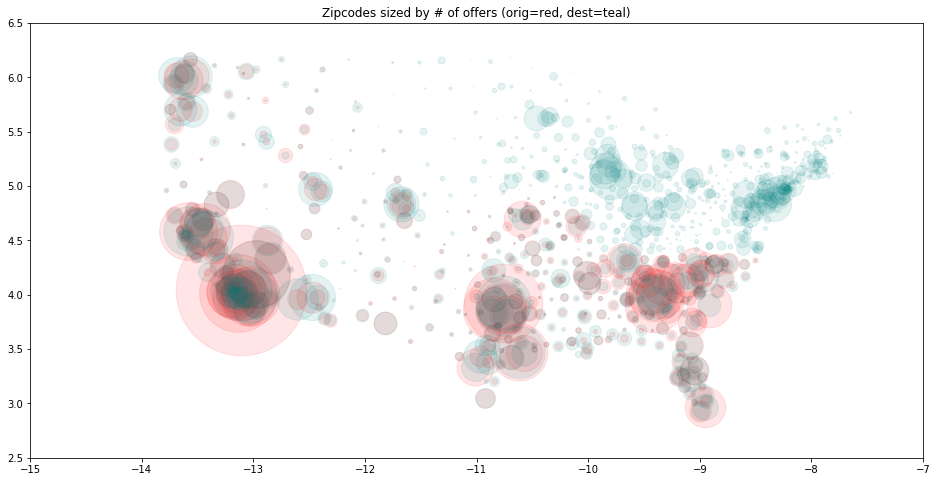

In [14]:
fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_sized_count_aggregation_visualization(oa,'ORIGIN_3DIGIT_ZIP',axs,
                                  "","red")
axs = zipcode_sized_count_aggregation_visualization(oa,'DESTINATION_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of offers (orig=red, dest=teal)","teal")

temp_oa = oa_orders
zipcode_counted_offers = (
    pd.concat([
    (
        temp_oa['ORIGIN_3DIGIT_ZIP']
        .value_counts()
        .reset_index(name='count')
    )
        ,
    (
        temp_oa['DESTINATION_3DIGIT_ZIP']
        .value_counts()
        .reset_index(name='count')
    
    )
], axis=0).groupby(["index"],as_index=False)
.agg({"count": np.sum})
.rename(columns={"index":"3DIGIT_ZIP"})
.merge(zipcode_coordinates,on=["3DIGIT_ZIP"])
)
fig, axs = plt.subplots(figsize=(16,10))
axs.set_title("Zipcodes sized by # of orders (both orig and dest summed together)")
for i in tqdm.tqdm(range(len(zipcode_counted_offers))):
    row = zipcode_counted_offers.iloc[i]
    x = row["X_COORD"]
    y = row["Y_COORD"]
    size = (row["count"])*0.2
    opacity = 0.1
    color = "purple"
    axs.scatter(x,y,s=size,c=color,alpha=opacity)

fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_sized_count_aggregation_visualization(oa_orders,'ORIGIN_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of orders (orig only)","red")

fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_sized_count_aggregation_visualization(oa_orders,'DESTINATION_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of orders (dest only)","teal")

100%|███████████████████████████████████████████████████████████████████████████████| 886/886 [00:01<00:00, 851.69it/s]


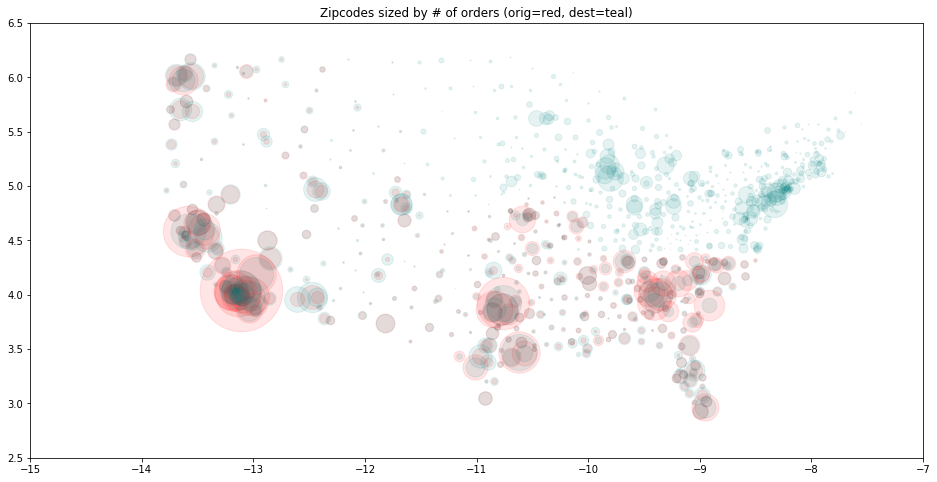

In [15]:
fig, axs = plt.subplots(figsize=(16,8))
axs = zipcode_sized_count_aggregation_visualization(oa_orders,'ORIGIN_3DIGIT_ZIP',axs,
                                  "","red")
axs = zipcode_sized_count_aggregation_visualization(oa_orders,'DESTINATION_3DIGIT_ZIP',axs,
                                  "Zipcodes sized by # of orders (orig=red, dest=teal)","teal")

**Evaluation**
* Points of Interest:
    * Southern California (LA, SD)
    * Bay Area
    * Seattle
    * Texas (Dallas & Houston)
    * Florida
    * Atlanta?
    * NYC
* Suggestions / Brainstorming Ideas
    * Maybe clustering can be done  this.
        * Treat the dot weights as a 3rd dimension (acts like an axis for urban vs rural) and do DBSCAN or KMeans Clustering.
        * So that metropolitan areas are treated as clumps

### Zipcodes by Avg Order Offer Amount

100%|███████████████████████████████████████████████████████████████████████████████| 858/858 [00:01<00:00, 830.79it/s]


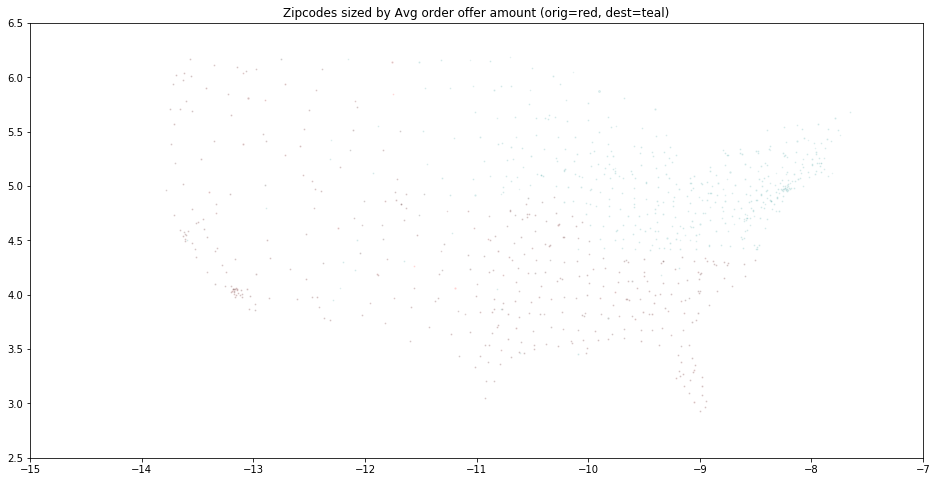

In [16]:
fig, axs = plt.subplots(figsize=(16,8))
temp_oa_df = oa[["ORIGIN_3DIGIT_ZIP","ORDER_OFFER_AMOUNT","REFERENCE_NUMBER"]].drop_duplicates()

temp_zipcode_groupby = get_temp_zipcode_groupby(temp_oa_df,"ORIGIN_3DIGIT_ZIP","ORDER_OFFER_AMOUNT")
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs, "", "red")

temp_oa_df = oa[["DESTINATION_3DIGIT_ZIP","ORDER_OFFER_AMOUNT","REFERENCE_NUMBER"]].drop_duplicates()
temp_zipcode_groupby = get_temp_zipcode_groupby(temp_oa_df,"DESTINATION_3DIGIT_ZIP","ORDER_OFFER_AMOUNT")
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs,
                                        "Zipcodes sized by Avg order offer amount (orig=red, dest=teal)","teal")
#axs.show()
#fig

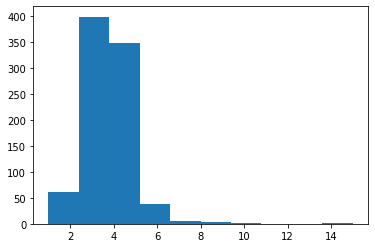

In [17]:
_= plt.hist(temp_zipcode_groupby["ORDER_OFFER_AMOUNT"])

By looking at a histogram of the groupby object (just for destination though), the shape is right-skewed, so the N-th poweris applied to the values to exaggerate it and make the current scatterplot more interpretable. Like say N=4

100%|███████████████████████████████████████████████████████████████████████████████| 858/858 [00:00<00:00, 898.20it/s]


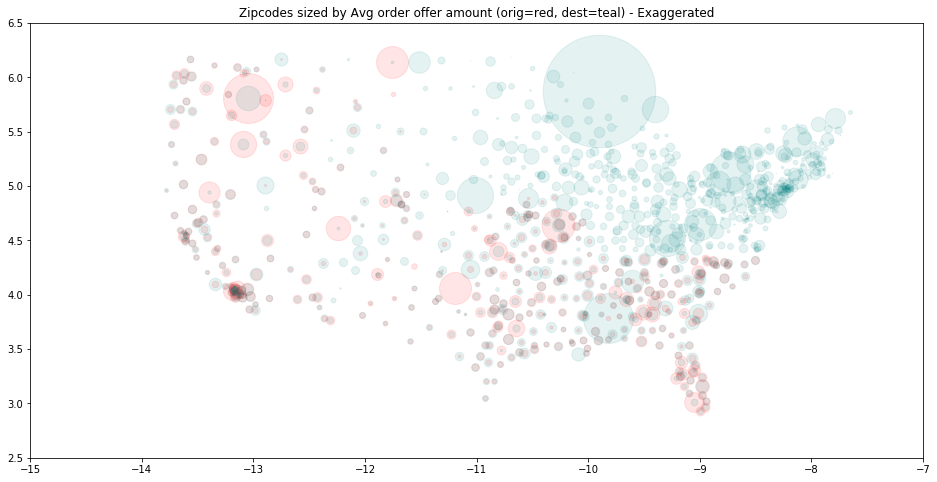

In [18]:
# Redoing the scatterplot but exagerrating differences to make it easier to interpret

fig, axs = plt.subplots(figsize=(16,8))
temp_oa_df = oa[["ORIGIN_3DIGIT_ZIP","ORDER_OFFER_AMOUNT","REFERENCE_NUMBER"]].drop_duplicates()

temp_zipcode_groupby = get_temp_zipcode_groupby(temp_oa_df,"ORIGIN_3DIGIT_ZIP","ORDER_OFFER_AMOUNT")
temp_zipcode_groupby["ORDER_OFFER_AMOUNT"] **= 4 # exagerration 
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs, "", "red")

temp_oa_df = oa[["DESTINATION_3DIGIT_ZIP","ORDER_OFFER_AMOUNT","REFERENCE_NUMBER"]].drop_duplicates()
temp_zipcode_groupby = get_temp_zipcode_groupby(temp_oa_df,"DESTINATION_3DIGIT_ZIP","ORDER_OFFER_AMOUNT")
temp_zipcode_groupby["ORDER_OFFER_AMOUNT"] **= 4 # exagerration 
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs,
        "Zipcodes sized by Avg order offer amount (orig=red, dest=teal) - Exaggerated","teal")
#axs.show()
#fig

**Evaluation**
* Big outlier in Minnesota/Wisconsin - this zipcode is the destination of the highest average of offers per order
* Parts of Ohio and Northeast are also destinations of a higher-than-usual average of offers per order
* Some zipcode in Idaho is the origin of the highest average of offers per order
* Florida and scattered parts in the south are also origins of a higher-than-usual average of offers per order

### Zipcodes by Avg Rate USD 

  0%|                                                                                          | 0/398 [00:00<?, ?it/s]c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
100%|███████████████████████████████████████████████████████████████████████████████| 858/858 [00:00<00:00, 955.40it/s]


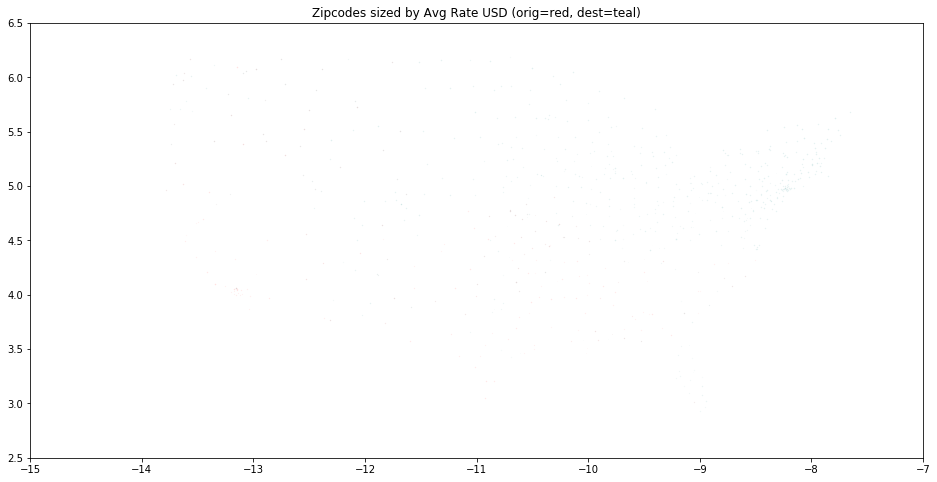

In [19]:
fig, axs = plt.subplots(figsize=(16,8))

temp_zipcode_groupby = get_temp_zipcode_groupby(oa,"ORIGIN_3DIGIT_ZIP","FULL_ZSCORE(LOG(RATE_USD))")
#temp_zipcode_groupby["FULL_ZSCORE(LOG(RATE_USD))"] *= 100 # exagerration 
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs, "", "red")

temp_zipcode_groupby = get_temp_zipcode_groupby(oa,"DESTINATION_3DIGIT_ZIP","FULL_ZSCORE(LOG(RATE_USD))")
#temp_zipcode_groupby["FULL_ZSCORE(LOG(RATE_USD))"] *= 100 # exagerration 
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs,
                                        "Zipcodes sized by Avg Rate USD (orig=red, dest=teal)","teal")
#axs.show()
#fig

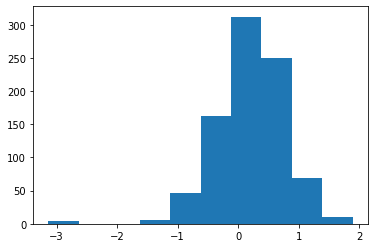

In [20]:
_= plt.hist(temp_zipcode_groupby["FULL_ZSCORE(LOG(RATE_USD))"])

By looking at a histogram of the groupby object (just for destination though), the shape is almost normal. Power can't be used to exagerrate differences so a binary cutoff (below -0.5 standard deviation) will be used. Though now all the dots are the same sizes.

100%|███████████████████████████████████████████████████████████████████████████████| 858/858 [00:01<00:00, 807.83it/s]


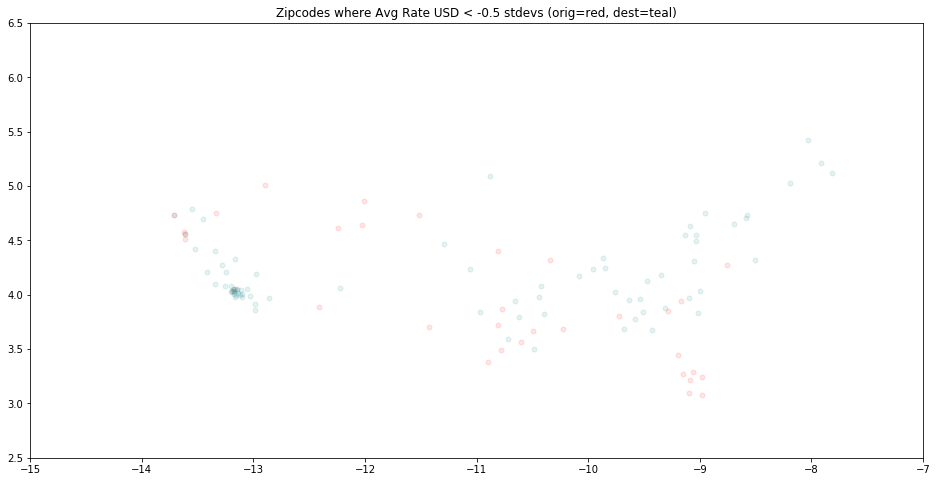

In [21]:
fig, axs = plt.subplots(figsize=(16,8))

temp_zipcode_groupby = get_temp_zipcode_groupby(oa,"ORIGIN_3DIGIT_ZIP","FULL_ZSCORE(LOG(RATE_USD))")
temp_zipcode_groupby["FULL_ZSCORE(LOG(RATE_USD))"] = (
    temp_zipcode_groupby["FULL_ZSCORE(LOG(RATE_USD))"] < -0.5
)*100
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs, "", "red")

temp_zipcode_groupby = get_temp_zipcode_groupby(oa,"DESTINATION_3DIGIT_ZIP","FULL_ZSCORE(LOG(RATE_USD))")
temp_zipcode_groupby["FULL_ZSCORE(LOG(RATE_USD))"] = (
    temp_zipcode_groupby["FULL_ZSCORE(LOG(RATE_USD))"] < -0.5
)*100
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs,
                                        "Zipcodes where Avg Rate USD < -0.5 stdevs (orig=red, dest=teal)","teal")
#axs.show()
#fig

**Evaluation**
* -

### Zipcodes by Avg % Relative Below-Average Rate USD

100%|███████████████████████████████████████████████████████████████████████████████| 858/858 [00:01<00:00, 854.28it/s]


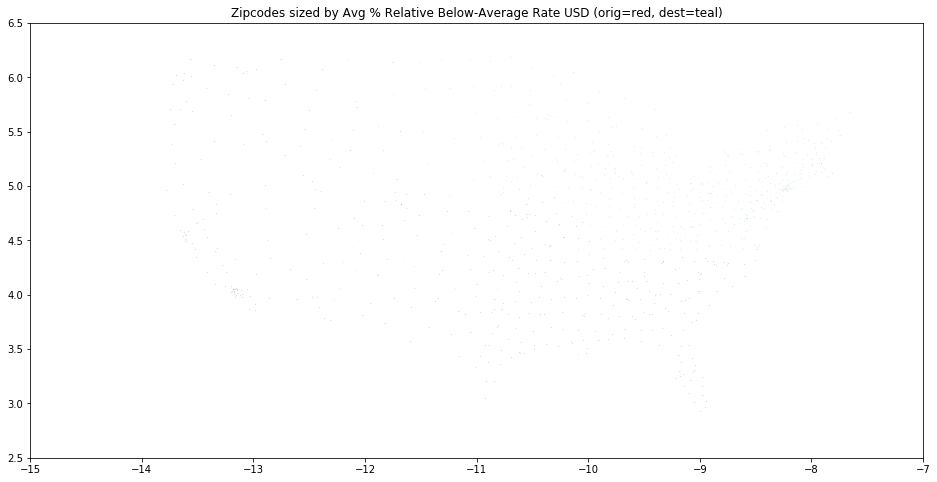

In [22]:
fig, axs = plt.subplots(figsize=(16,8))

temp_zipcode_groupby = get_temp_zipcode_groupby(oa,"ORIGIN_3DIGIT_ZIP","GROUPWISE_ZSCORE(LOG(RATE_USD))<=0")
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs, "", "red")

temp_zipcode_groupby = get_temp_zipcode_groupby(oa,"DESTINATION_3DIGIT_ZIP","GROUPWISE_ZSCORE(LOG(RATE_USD))<=0")
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs,
        "Zipcodes sized by Avg % Relative Below-Average Rate USD (orig=red, dest=teal)","teal")
#axs.show()
#fig

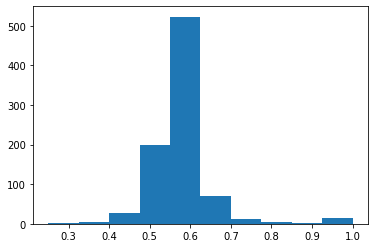

In [23]:
_= plt.hist(temp_zipcode_groupby["GROUPWISE_ZSCORE(LOG(RATE_USD))<=0"])

By looking at a histogram of the groupby object (just for destination though), the shape is almost normal and not right-skewed. But unlike the last plot, this is all positive, so maybe it can be valid to un-log (np.exp) to make it right-skewed, then do power, to exagerrate differences.

100%|███████████████████████████████████████████████████████████████████████████████| 858/858 [00:00<00:00, 858.01it/s]


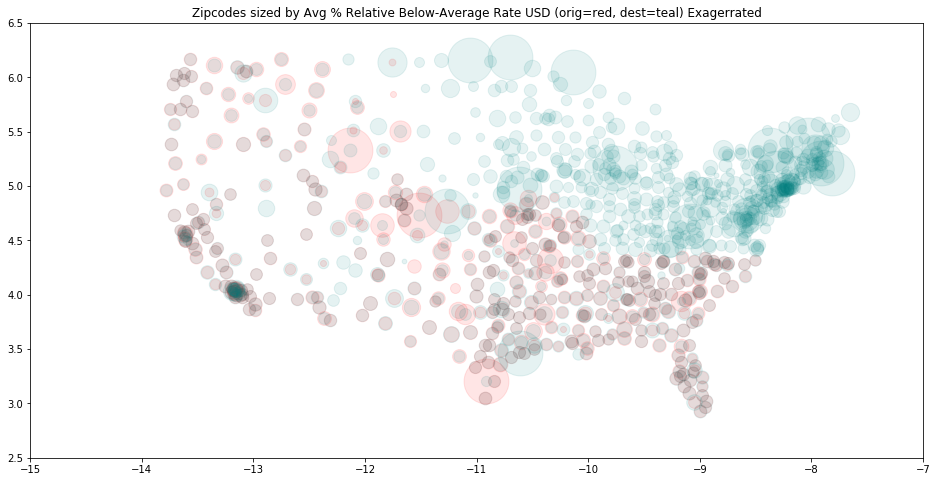

In [24]:
# Redoing the scatterplot but exagerrating differences to make it easier to interpret

fig, axs = plt.subplots(figsize=(16,8))

temp_zipcode_groupby = get_temp_zipcode_groupby(oa,"ORIGIN_3DIGIT_ZIP","GROUPWISE_ZSCORE(LOG(RATE_USD))<=0")
temp_zipcode_groupby["GROUPWISE_ZSCORE(LOG(RATE_USD))<=0"] = (
    (np.exp(temp_zipcode_groupby["GROUPWISE_ZSCORE(LOG(RATE_USD))<=0"])**6)*20
) # exagerrated
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs, "", "red")

temp_zipcode_groupby = get_temp_zipcode_groupby(oa,"DESTINATION_3DIGIT_ZIP","GROUPWISE_ZSCORE(LOG(RATE_USD))<=0")
temp_zipcode_groupby["GROUPWISE_ZSCORE(LOG(RATE_USD))<=0"] = (
    (np.exp(temp_zipcode_groupby["GROUPWISE_ZSCORE(LOG(RATE_USD))<=0"])**6)*20
) # exagerrated
axs = zipcode_aggregation_visualization(temp_zipcode_groupby, axs,
        "Zipcodes sized by Avg % Relative Below-Average Rate USD (orig=red, dest=teal) Exagerrated","teal")
#axs.show()
#fig

**Evaluation**
* This map means zipcodes that have bigger circles tend to be part of offers that are relatively cheapest (compared to others within any given order)

**Conclusion**

* End of plots with zipcode.

**Brainstorming Ideas**

* Maybe clustering can be done  this.
    * Treat the dot weights as a 3rd dimension (acts like an axis for urban vs rural) and do DBSCAN or KMeans Clustering.
    * So that metropolitan areas are treated as clumps


## Path Visualizations

In [25]:
agg_column_names = [
 'PATH_ORDER_AMOUNT',
 'LOG(PATH_ORDER_AMOUNT)',
 'PATH_OFFER_AMOUNT',
 'LOG(PATH_OFFER_AMOUNT)',
 'ORDER_OFFER_AMOUNT',
 'LOG(ORDER_OFFER_AMOUNT)',
 'RATE_USD',
 'LOG(RATE_USD)',
 'GROUPWISE_ZSCORE(LOG(RATE_USD))',
 'GROUPWISE_ZSCORE(LOG(RATE_USD))>0',
 'GROUPWISE_ZSCORE(LOG(RATE_USD))<=0',
  "GROUPWISE_MAX(GROUPWISE_ZSCORE(LOG(RATE_USD)))",
  "GROUPWISE_MIN(GROUPWISE_ZSCORE(LOG(RATE_USD)))",
 'FULL_ZSCORE(LOG(RATE_USD))',
]

In [26]:
aggdict = dict()
for column_name in agg_column_names:
    aggdict[column_name] = np.mean
connections = (oa.groupby(["X_COORD","Y_COORD","X_COORD_DEST","Y_COORD_DEST"],as_index=False).agg(aggdict))
#connections = connections.sort_values(["X_COORD","Y_COORD","X_COORD_DEST","Y_COORD_DEST"])

def remove_hawaii_outlier(connections):
    hawaii = connections["X_COORD_DEST"].min()
    connections = connections[connections["X_COORD_DEST"] > hawaii]
    return connections
def remove_min_outlier(connections, column_name):
    outlier = connections[column_name].min()
    connections = connections[connections[column_name] > outlier]
    return connections

In [27]:
def get_line(i):
    row = connections.iloc[i]
    ox = row["X_COORD"]#.values[0]
    oy = row["Y_COORD"]#.values[0]
    dx = row["X_COORD_DEST"]#.values[0]
    dy = row["Y_COORD_DEST"]#.values[0]
    return [(ox, oy), (dx, dy)]
    
lines = [get_line(i) for i in tqdm.tqdm(range(connections.shape[0]))]

100%|██████████████████████████████████████████████████████████████████████████| 27257/27257 [00:03<00:00, 8753.55it/s]


In [28]:
import matplotlib
from matplotlib import cm

sigmoid = lambda x: x/(1+np.exp(-x))
def visibility_modifier_array(x):
    if agg_column_name not in ["FULL_ZSCORE(LOG(RATE_USD))","GROUPWISE_ZSCORE(LOG(RATE_USD))"]:
        return np.log1p(x) 
    else:
        if agg_column_name == "GROUPWISE_ZSCORE(LOG(RATE_USD))":
            return x#**3
        return x
def groupwise_min_max_scale(x):
    numerator = (x - connections["GROUPWISE_MIN(GROUPWISE_ZSCORE(LOG(RATE_USD)))"])
    denominator = (
connections["GROUPWISE_MAX(GROUPWISE_ZSCORE(LOG(RATE_USD)))"] - connections["GROUPWISE_MIN(GROUPWISE_ZSCORE(LOG(RATE_USD)))"]
        )
    rescaled_x = numerator/denominator
    rescaled_x = np.nan_to_num(rescaled_x,0,posinf=0,neginf=0)
    return rescaled_x
def min_max_scale(x):
    numerator = (x - np.min(x))
    denominator = (np.max(x) - np.min(x))
    rescaled_x = numerator/denominator
    rescaled_x = np.nan_to_num(rescaled_x,0,posinf=0,neginf=0)
    return rescaled_x
def visibility_modifier_linewidth(x):
    if agg_column_name not in ["FULL_ZSCORE(LOG(RATE_USD))","GROUPWISE_ZSCORE(LOG(RATE_USD))"]:
        return np.log1p(x)  
    else:
        # if x is an array that has numbers below 0 (i.e. a z-scored column), rescale it to be positive
        # since plotted linewidth cannot understand negative width
        # use min-max-scaling to make it positive from 0 to 1
        
        if agg_column_name == "GROUPWISE_ZSCORE(LOG(RATE_USD))":
            rescaled_x = groupwise_min_max_scale(x)
            
            rescaled_x = (1-rescaled_x)**10
        else:
            rescaled_x = min_max_scale(x)
        return rescaled_x**10
def get_values(connections, agg_column_name):
    values = connections[agg_column_name]
    # re-weight the values by usage
    #values /= connections["PATH_ORDER_AMOUNT"]
    return values
def get_linewidths(connections, agg_column_name):
    values = get_values(connections, agg_column_name)
    return visibility_modifier_linewidth(values)
def get_array(connections, agg_column_name):
    values = get_values(connections, agg_column_name)
    return visibility_modifier_array(values)
def get_rgba(connections, agg_column_name):
    values = get_values(connections, agg_column_name)
    #cmap = matplotlib.cm.get_cmap('Spectral')
    cmap = cm.jet
    #cmap = cm.hsv
    norm = matplotlib.colors.Normalize(vmin=np.min(values), vmax=np.max(values))
    rgba_colors = np.array([cmap(norm(x)) for x in values])
    if agg_column_name in ["GROUPWISE_ZSCORE(LOG(RATE_USD))"]:
        alphas = (groupwise_min_max_scale(values))#*0.001
    else:
        alphas = (min_max_scale(values))#*0.001
    rgba_colors[:,-1] = (alphas)*0.00001
    return rgba_colors

### Paths by Avg Offer Amount

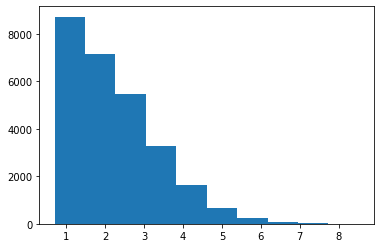

In [29]:
agg_column_name = "LOG(PATH_OFFER_AMOUNT)"
_ = plt.hist(connections[agg_column_name])

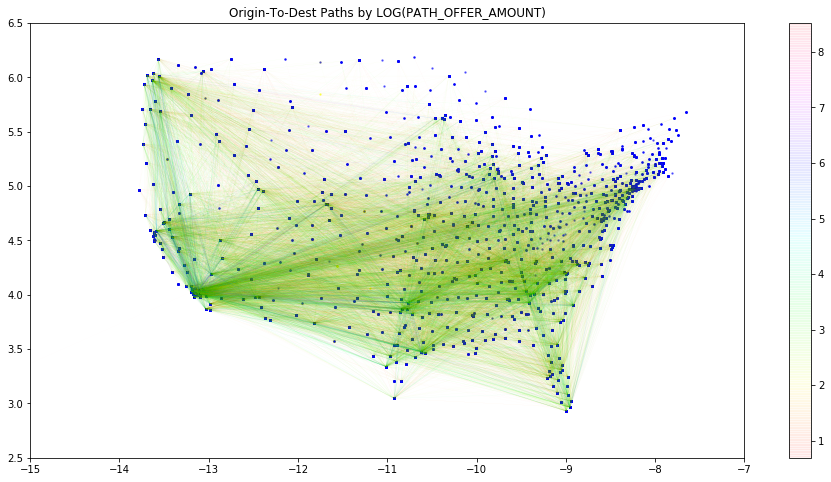

In [30]:
lc = mc.LineCollection(lines, 
                       array = (get_values(connections, agg_column_name)),
                       cmap="hsv",
                       linewidths = (get_values(connections, agg_column_name))*0.1,
                       alpha=0.05
                      )
fig2, ax2 = plt.subplots(figsize=(16,8))
ax2.set_ylim((Y_LOWER_BOUND, Y_UPPER_BOUND))
ax2.set_xlim((X_LOWER_BOUND,X_UPPER_BOUND))
ax2.scatter(connections["X_COORD"], connections["Y_COORD"], alpha=0.5, c="yellow", s=2)
ax2.scatter(connections["X_COORD_DEST"], connections["Y_COORD_DEST"], alpha=0.5, c="blue", s=2)
ax2.add_collection(lc)
#ax2.autoscale()
ax2.margins(0.1)
ax2.set_title("Origin-To-Dest Paths by {0}".format(agg_column_name))
fig2.colorbar(lc)

**Evaluation**
* Heavy activity in the South (Dallas and Atlanta?)
* Heavy corridor of activity between SoCal and NYC

### Paths by Avg Order Amount

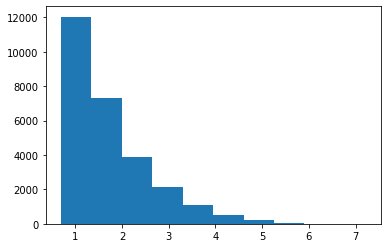

In [31]:
agg_column_name = "LOG(PATH_ORDER_AMOUNT)"
_ = plt.hist(connections[agg_column_name])

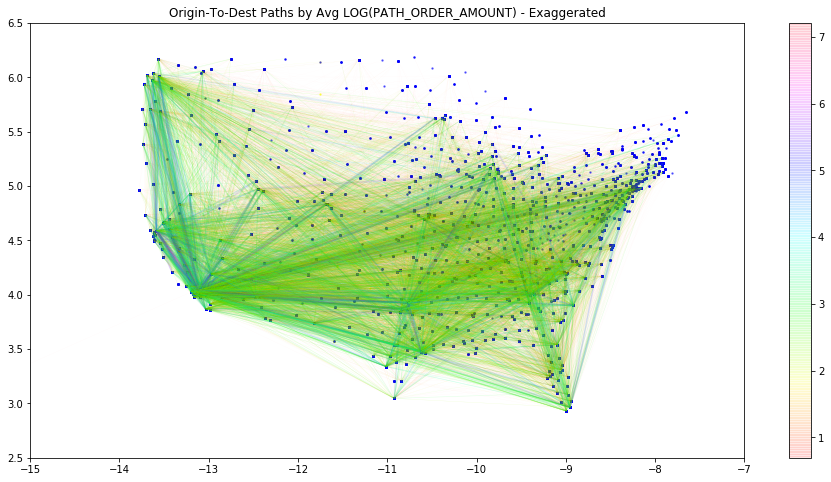

In [32]:
lc = mc.LineCollection(lines, 
                       array = (get_values(connections, agg_column_name)),
                       cmap="hsv",
                       linewidths = (get_values(connections, agg_column_name)*0.25)**2,
                       alpha=0.1
                      )
fig2, ax2 = plt.subplots(figsize=(16,8))
ax2.set_ylim((Y_LOWER_BOUND, Y_UPPER_BOUND))
ax2.set_xlim((X_LOWER_BOUND,X_UPPER_BOUND))
ax2.scatter(connections["X_COORD"], connections["Y_COORD"], alpha=0.5, c="yellow", s=2)
ax2.scatter(connections["X_COORD_DEST"], connections["Y_COORD_DEST"], alpha=0.5, c="blue", s=2)
ax2.add_collection(lc)
#ax2.autoscale()
ax2.margins(0.1)
ax2.set_title("Origin-To-Dest Paths by Avg {0} - Exaggerated".format(agg_column_name))
fig2.colorbar(lc)

**Evaluation**
* Strong amount of orders among Seattle, Bay Area, SoCal, Dallas, Chicago, Florida, and NYC

### Paths by Avg Order Offer Amount

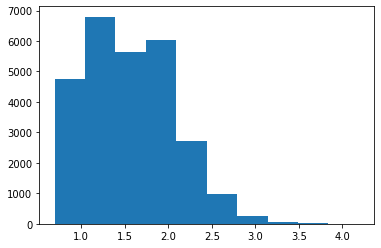

In [33]:
agg_column_name = "LOG(ORDER_OFFER_AMOUNT)"
_ = plt.hist(connections[agg_column_name])

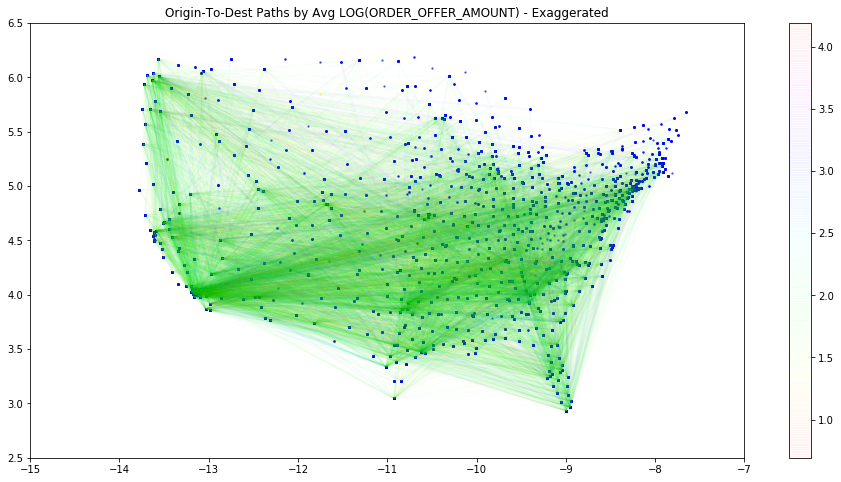

In [34]:
lc = mc.LineCollection(lines, 
                       array = (get_values(connections, agg_column_name)),
                       cmap="hsv",
                       linewidths = (get_values(connections, agg_column_name)*0.5)**2,
                       alpha=0.025
                      )
fig2, ax2 = plt.subplots(figsize=(16,8))
ax2.set_ylim((Y_LOWER_BOUND, Y_UPPER_BOUND))
ax2.set_xlim((X_LOWER_BOUND,X_UPPER_BOUND))
ax2.scatter(connections["X_COORD"], connections["Y_COORD"], alpha=0.5, c="yellow", s=2)
ax2.scatter(connections["X_COORD_DEST"], connections["Y_COORD_DEST"], alpha=0.5, c="blue", s=2)
ax2.add_collection(lc)
#ax2.autoscale()
ax2.margins(0.1)
ax2.set_title("Origin-To-Dest Paths by Avg {0} - Exaggerated".format(agg_column_name))
fig2.colorbar(lc)

### Paths by Avg Rate USD

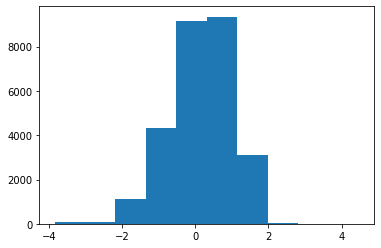

In [35]:
agg_column_name = "FULL_ZSCORE(LOG(RATE_USD))"
_ = plt.hist(connections[agg_column_name])

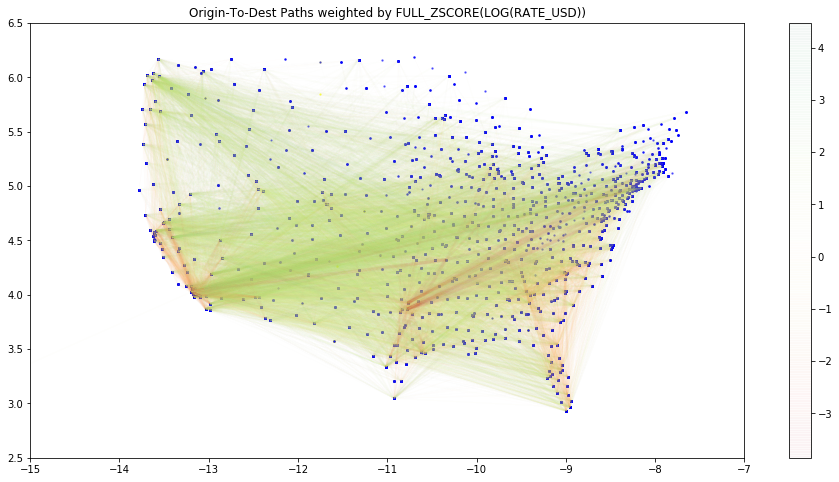

In [36]:
CMAP = "hsv"
CMAP = "RdYlGn"
lc = mc.LineCollection(lines, 
                       array = (get_values(connections, agg_column_name)),
                       cmap=CMAP,
                       linewidths = (
                           ((get_values(connections, agg_column_name)))
                       ),
                       alpha=0.025
                      )
fig2, ax2 = plt.subplots(figsize=(16,8))
ax2.set_ylim((Y_LOWER_BOUND, Y_UPPER_BOUND))
ax2.set_xlim((X_LOWER_BOUND,X_UPPER_BOUND))
ax2.scatter(connections["X_COORD"], connections["Y_COORD"], alpha=0.5, c="yellow", s=2)
ax2.scatter(connections["X_COORD_DEST"], connections["Y_COORD_DEST"], alpha=0.5, c="blue", s=2)
ax2.add_collection(lc)
#ax2.autoscale()
ax2.margins(0.1)
ax2.set_title("Origin-To-Dest Paths weighted by {0}".format(agg_column_name))
fig2.colorbar(lc)

**Evaluation**
* Dallas(?)-to-NYC have relatively cheap paths
* SoCal-to-Bay Area have relatively cheap paths
* Any Paths that have Florida is also relatively cheap

### Zipcodes by Avg % Relative Below-Average Rate USD

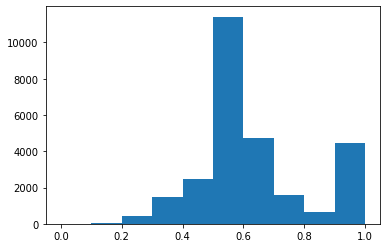

In [37]:
agg_column_name = "GROUPWISE_ZSCORE(LOG(RATE_USD))<=0"
_ = plt.hist(connections[agg_column_name] )

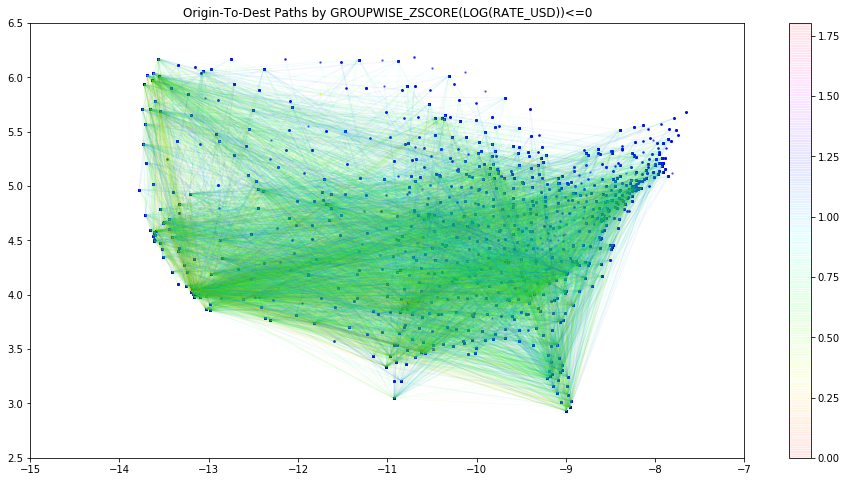

In [38]:
CMAP = "hsv"
#CMAP = "RdYlGn"
weight = get_values(connections, "LOG(ORDER_OFFER_AMOUNT)")
weight = get_values(connections, "LOG(PATH_ORDER_AMOUNT)")
#weight = get_values(connections, "LOG(PATH_OFFER_AMOUNT)")

adjusted_values = groupwise_min_max_scale(get_values(connections, agg_column_name))/weight
lc = mc.LineCollection(lines, 
                       array = (
                           adjusted_values
                           #get_values(connections, agg_column_name)
                       ),
                       cmap=CMAP,
                       linewidths =(
                           adjusted_values
                           #(np.exp(get_values(connections, agg_column_name))**6)/100
                                   ),
                       alpha=0.05
                      )
fig2, ax2 = plt.subplots(figsize=(16,8))
ax2.set_ylim((Y_LOWER_BOUND, Y_UPPER_BOUND))
ax2.set_xlim((X_LOWER_BOUND,X_UPPER_BOUND))
ax2.scatter(connections["X_COORD"], connections["Y_COORD"], alpha=0.5, c="yellow", s=2)
ax2.scatter(connections["X_COORD_DEST"], connections["Y_COORD_DEST"], alpha=0.5, c="blue", s=2)
ax2.add_collection(lc)
#ax2.autoscale()
ax2.margins(0.1)
ax2.set_title("Origin-To-Dest Paths by {0}".format(agg_column_name))
fig2.colorbar(lc)

**Evaluation**
* Visualization doesn't seem too helpful. GROUPWISE_ZSCORE(LOG(RATE_USD))<=0 seems to be not correlated with any spatial patterns...

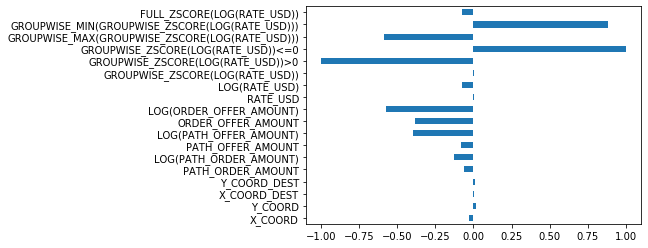

In [43]:
connections.corr()["GROUPWISE_ZSCORE(LOG(RATE_USD))<=0"].plot(kind="barh")

* The strongest feature that isn't related to  "GROUPWISE_ZSCORE(LOG(RATE_USD))<=0" is LOG(ORDER_OFFER_AMOUNT)
* I.e. the higher the amount of offers per order a path gets, the more likely there will be cheap offers ... a bit obvious and due to bias

In [46]:
connections_ = connections.copy()
connections_["GROUPWISE_ZSCORE(LOG(RATE_USD))<=0/LOG(ORDER_OFFER_AMOUNT)"] = (
    connections["GROUPWISE_ZSCORE(LOG(RATE_USD))<=0"]/connections["LOG(ORDER_OFFER_AMOUNT)"]
)
connections_

In [52]:
#connections_.corr()["GROUPWISE_ZSCORE(LOG(RATE_USD))<=0/LOG(ORDER_OFFER_AMOUNT)"].abs().sort_values()#.plot(kind="barh")

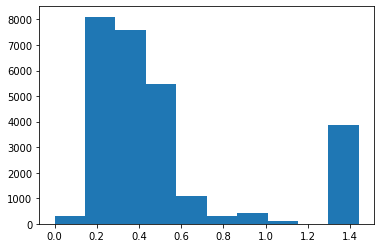

In [53]:
agg_column_name = "GROUPWISE_ZSCORE(LOG(RATE_USD))<=0/LOG(ORDER_OFFER_AMOUNT)"
_ = plt.hist(connections_[agg_column_name])

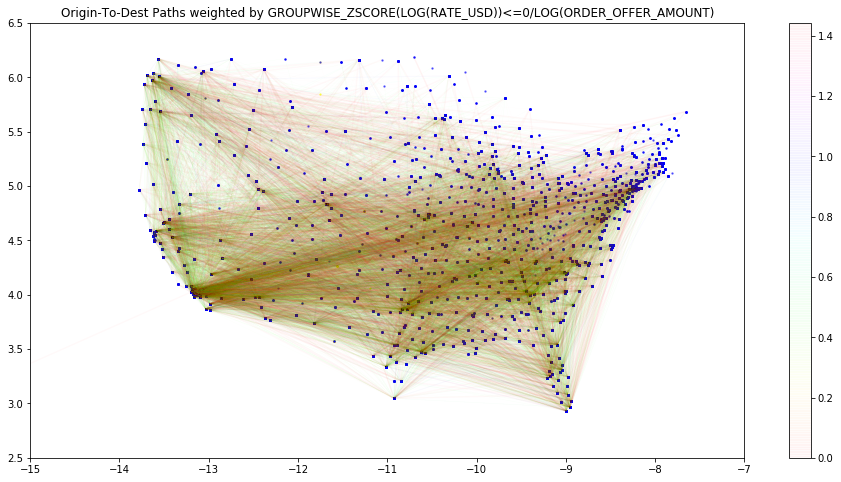

In [55]:
CMAP = "hsv"
#CMAP = "RdYlGn"
lc = mc.LineCollection(lines, 
                       array = (get_values(connections_, agg_column_name)),
                       cmap=CMAP,
                       linewidths = (
                           ((get_values(connections_, agg_column_name)))
                       ),
                       alpha=0.025
                      )
fig2, ax2 = plt.subplots(figsize=(16,8))
ax2.set_ylim((Y_LOWER_BOUND, Y_UPPER_BOUND))
ax2.set_xlim((X_LOWER_BOUND,X_UPPER_BOUND))
ax2.scatter(connections["X_COORD"], connections["Y_COORD"], alpha=0.5, c="yellow", s=2)
ax2.scatter(connections["X_COORD_DEST"], connections["Y_COORD_DEST"], alpha=0.5, c="blue", s=2)
ax2.add_collection(lc)
#ax2.autoscale()
ax2.margins(0.1)
ax2.set_title("Origin-To-Dest Paths weighted by {0}".format(agg_column_name))
fig2.colorbar(lc)